# data preprocessing (label encoding, rename, dan handling imbalanced data)

In [28]:
import pandas as pd

In [29]:
# Load dataset
data = pd.read_csv('../data/Sleep_health_and_lifestyle_dataset.csv')

memastikan datanya tetap lengkap untuk digunakan dalam analisis selanjutnya

In [30]:
# Mengisi baris yang mengandung nilai kosong
data['Sleep Disorder'] = data['Sleep Disorder'].fillna('Healthy Sleep')
data['Sleep Disorder'].value_counts()

Sleep Disorder
Healthy Sleep    219
Sleep Apnea       78
Insomnia          77
Name: count, dtype: int64

untuk dapat menganalisis yang lebih terperinci terhadap data tekanan darah.

In [31]:
# Memisahkan kolom 'Blood Pressure' menjadi dua kolom 'Systolic' dan 'Diastolic'
data[['Systolic', 'Diastolic']] = data['Blood Pressure'].str.split('/', expand=True)
data['Systolic'] = data['Systolic'].astype(float)
data['Diastolic'] = data['Diastolic'].astype(float)

data.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder,Systolic,Diastolic
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,Healthy Sleep,126.0,83.0
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,Healthy Sleep,125.0,80.0
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,Healthy Sleep,125.0,80.0
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea,140.0,90.0
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea,140.0,90.0


mengurangi kompleksitas data dan memfokuskan analisis pada fitur-fitur yang diperlukan

In [32]:
# Menghapus kolom yang tidak diperlukan
data = data.copy()
data = data.drop(['Person ID', 'Blood Pressure', 'Occupation'], axis=1)
data.head()

,Gender,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Systolic,Diastolic
0,Male,27,6.1,6,42,6,Overweight,77,4200,Healthy Sleep,126.0,83.0
1,Male,28,6.2,6,60,8,Normal,75,10000,Healthy Sleep,125.0,80.0
2,Male,28,6.2,6,60,8,Normal,75,10000,Healthy Sleep,125.0,80.0
3,Male,28,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140.0,90.0
4,Male,28,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140.0,90.0


In [33]:
from sklearn.preprocessing import LabelEncoder
import joblib
from imblearn.over_sampling import SMOTE
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

pada dasarnya normal weight sama normal sama saja berdasarkan data visualization

In [34]:
# Mengganti nilai 'Normal Weight' menjadi 'Normal' pada kolom 'BMI Category'
data['BMI Category'] = data['BMI Category'].replace("Normal Weight", "Normal")
data['BMI Category'].value_counts()

BMI Category
Normal        216
Overweight    148
Obese          10
Name: count, dtype: int64

model yang akan digunakan hanya dapat mengolah data numerik

In [35]:
# Inisialisasi label encoder untuk kolom kategorikal
label_encoders = {}
cat_columns = ['BMI Category', 'Sleep Disorder', 'Gender']
for col in cat_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

data.head()

,Gender,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Systolic,Diastolic
0,1,27,6.1,6,42,6,2,77,4200,0,126.0,83.0
1,1,28,6.2,6,60,8,0,75,10000,0,125.0,80.0
2,1,28,6.2,6,60,8,0,75,10000,0,125.0,80.0
3,1,28,5.9,4,30,8,1,85,3000,2,140.0,90.0
4,1,28,5.9,4,30,8,1,85,3000,2,140.0,90.0


In [36]:
# Simpan label encoder untuk 'Sleep Disorder'
joblib.dump(label_encoders['Sleep Disorder'], 'sleep_disorder_label_encoder.pkl')

['sleep_disorder_label_encoder.pkl']

In [37]:
# Memisahkan fitur dan label
X = data.drop('Sleep Disorder', axis=1)
y = data['Sleep Disorder']

mengatasi masalah ketidakseimbangan kelas di dataset

In [38]:
# Terapkan SMOTE untuk menangani ketidakseimbangan kelas
smote = SMOTE(random_state=1)
X_resampled, y_resampled = smote.fit_resample(X, y)

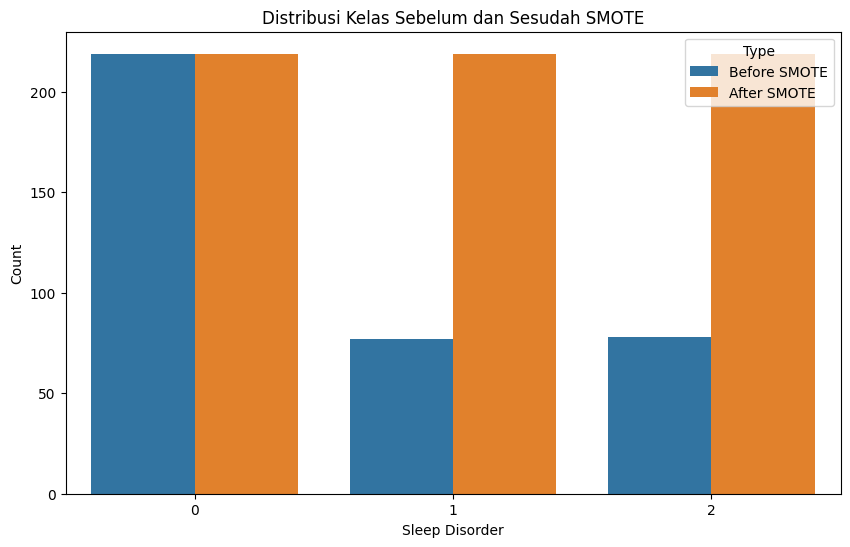

In [39]:
counter_before = Counter(y)
counter_after = Counter(y_resampled)

before_smote = pd.DataFrame.from_dict(counter_before, orient='index').reset_index()
before_smote.columns = ['Sleep Disorder', 'Count']
before_smote['Type'] = 'Before SMOTE'

after_smote = pd.DataFrame.from_dict(counter_after, orient='index').reset_index()
after_smote.columns = ['Sleep Disorder', 'Count']
after_smote['Type'] = 'After SMOTE'

smote_df = pd.concat([before_smote, after_smote], axis=0)

plt.figure(figsize=(10, 6))
sns.barplot(x='Sleep Disorder', y='Count', hue='Type', data=smote_df)
plt.title('Distribusi Kelas Sebelum dan Sesudah SMOTE')
plt.xlabel('Sleep Disorder')
plt.ylabel('Count')
plt.show()

# modeling

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

untuk melatih model (train) dan mengevaluasi kinerja model (test)

In [41]:
# Bagi data menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [42]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [43]:
# Fungsi untuk melatih model dan mengembalikan metrik evaluasi
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    return accuracy, precision, recall, f1

evaluasi algoritma yang memungkinkan untuk digunakan

In [44]:
# Evaluasi keempat model
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
}

results = {}
for model_name, model in models.items():
    results[model_name] = evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test)

In [45]:
# Mengonversi hasil ke dalam DataFrame
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
data = []
for metric_index, metric in enumerate(metrics):
    for model_name, model in models.items():
        value = results[model_name][metric_index]
        data.append({
            'Model': model_name,
            'Metric': metric,
            'Value': value
        })

df = pd.DataFrame(data)

In [46]:
# Menentukan warna untuk bar tertinggi
def get_color(row):
    if row['Value'] == df[(df['Metric'] == row['Metric'])]['Value'].max():
        return 'darkblue'
    return 'lightblue'

df['Color'] = df.apply(get_color, axis=1)

# Create subplots 2x2
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=metrics,
    shared_xaxes=True,
    vertical_spacing=0.1,
    horizontal_spacing=0.1
)

# Add bar charts for each metric
for i, metric in enumerate(metrics):
    metric_df = df[df['Metric'] == metric]
    row = i // 2 + 1
    col = i % 2 + 1
    fig.add_trace(
        go.Bar(
            x=metric_df['Model'],
            y=metric_df['Value'],
            marker_color=metric_df['Color'],
            name=metric
        ),
        row=row, col=col
    )

# Update layout
fig.update_layout(
    title_text='Comparison of Models by Metrics',
    showlegend=False,
    template='plotly_white'
)

# Show plot
fig.show()

Pencarian Hyperparameter Terbaik untuk Model RandomForestClassifier

In [47]:
# Definisikan parameter grid untuk GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Inisialisasi model
rf = RandomForestClassifier(random_state=42)

# Grid Search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Dapatkan model terbaik
best_model = grid_search.best_estimator_


Fitting 3 folds for each of 216 candidates, totalling 648 fits


In [48]:
# Evaluasi pentingnya fitur
importances = best_model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot pentingnya fitur menggunakan plotly.express
fig = px.bar(importance_df, x='Importance', y='Feature', orientation='h', title='Feature Importances',
             labels={'Importance': 'Importance Score', 'Feature': 'Feature Name'}, 
             color='Importance', color_continuous_scale='Blues',)

fig.update_layout(yaxis={'categoryorder': 'total ascending'}, template='plotly_dark')
fig.show()

In [49]:
# Simpan model dan nama fitur ke file
model_info = {
    'model': best_model,
    'scaler': scaler,
    'feature_names': X.columns.tolist()
}
joblib.dump(model_info, 'sleep_disorder_model.pkl')

['sleep_disorder_model.pkl']

# prediction on new data

In [50]:
# Load model dan label encoder
model_info = joblib.load('sleep_disorder_model.pkl')
best_model = model_info['model']
scaler = model_info['scaler']
feature_names = model_info['feature_names']
sleep_disorder_label_encoder = joblib.load('sleep_disorder_label_encoder.pkl')

In [51]:
# Tampilkan nama fitur
print("Nama Fitur:", feature_names)

Nama Fitur: ['Gender', 'Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'BMI Category', 'Heart Rate', 'Daily Steps', 'Systolic', 'Diastolic']


In [52]:
# Contoh data baru untuk prediksi
new_data = pd.DataFrame({
    'Gender': [1],
    'Age': [25],
    'Sleep Duration': [7],
    'Quality of Sleep': [6],
    'Physical Activity Level': [5],
    'Stress Level': [4],
    'BMI Category': [0],
    'Heart Rate': [100],
    'Daily Steps': [1000],
    'Systolic': [80],
    'Diastolic': [60]
})

In [53]:
# Pastikan data baru juga diskalakan
new_data_scaled = scaler.transform(new_data)

In [54]:
# Prediksi gangguan tidur
prediction = model.predict(new_data_scaled)
predicted_label = sleep_disorder_label_encoder.inverse_transform(prediction)
print("Predicted Sleep Disorder:", predicted_label[0])

Predicted Sleep Disorder: Healthy Sleep
